<table style="width: 100%; border-style: none;">
<tr style="border-style: none">
<td style="border-style: none; width: 1%; font-size: 16px">Institut f&uuml;r Theoretische Physik<br /> Universit&auml;t zu K&ouml;ln</td>
<td style="border-style: none; width: 1%; font-size: 16px">&nbsp;</td>
<td style="border-style: none; width: 1%; text-align: right; font-size: 16px">Prof. Dr. Simon Trebst<br />Peter Br&ouml;cker</td>
</tr>
</table>
<hr>
<h1 style="font-weight:bold; text-align: center; margin: 0px; padding:0px;">Computerphysik</h1>
<h1 style="font-weight:bold; text-align: center; margin: 0px; padding:0px;">&Uuml;bungsblatt 5</h1>
<hr>
<h3 style="font-weight:bold; text-align: center; margin: 0px; padding:0px; margin-bottom: 20px;">Sommersemester 2016</h3>

**Website:** [http://www.thp.uni-koeln.de/trebst/Lectures/2016-CompPhys.shtml](http://www.thp.uni-koeln.de/trebst/Lectures/2016-CompPhys.shtml)

**Abgabe**: Montag, 23. Mai, 2016 vor der Vorlesung

**Name**: <font color="red">Michel Vielmetter</font>

**Matrikelnummer**: <font color="red">5920493</font>

<table style="border-style: none; width: 100%"><tr style="border-style: none;">
<td style="border-style: none; width: 1%; font-size: 20px; font-weight: bold">Monde auf der Überholspur</td>
<td style="border-style: none; width: 1%; text-align: right">(5 Punkte)</td></tr></table>

Die Monde **Janus** und **Epimetheus** umkreisen den Planeten Saturn *koorbital*, d.h. auf nahezu der gleichen Bahn.
Bemerkenswerterweise ist dabei der Bahnunterschied zwischen dem inneren und dem äußeren der beiden Monde deutlich
kleiner als deren Durchmesser. Alle vier Jahre begegnen sich die beiden Monde, da der innere Mond ein wenig schneller unterwegs ist als der Äußere. Wieso es dabei nicht zu einer Kollision kommt, wollen wir in dieser Aufgabe untersuchen.

Dazu wollen wir das **3-Körper-System** aus Saturn, Janus und  Epimetheus simulieren. Für die Simulation bewegen wir uns ins Bezugssystem des Saturn. Zwischen zwei Körpern wirkt dann eine Gravitationskraft gemäß

\begin{equation}
\mathbf{F}_{12}=-G\frac{m_1 m_2}{|\mathbf{r}_1-\mathbf{r}_2|^3}\left(\mathbf{r}_1-\mathbf{r}_2\right),
\end{equation}

wobei wir die Gravitationskonstante $G = 1$ setzen (wodurch sich die Größen der Parameter natürlich von den realistischen unterscheiden). Berechnen Sie die Bahnen der Monde mittels des **Verlet**-Verfahrens und plotten Sie die Bahnkurven der Monde. Verwenden Sie folgende Startwerte:

\begin{align*}
m_1 &= 1 \\
m_2 &= 4 \\
m_{\text{Saturn}} &= 4\times10^4 \\
\mathbf{r}_1 &= (-155, 0) \quad \frac{d\mathbf{r}_1}{dt} = (0, -16.1) \\
\mathbf{r}_2 &= (150, 0), \quad \frac{d\mathbf{r}_2}{dt} = (0, 16.3)
\end{align*}

In [1]:
# Only run this once: Because Julia!
type Body{T <: Number}
    mass::Int64
    r::Vector{T}
    v::Vector{T}
end

copy(ref::Body) = Body(ref.mass, Base.copy(ref.r), Base.copy(ref.v));

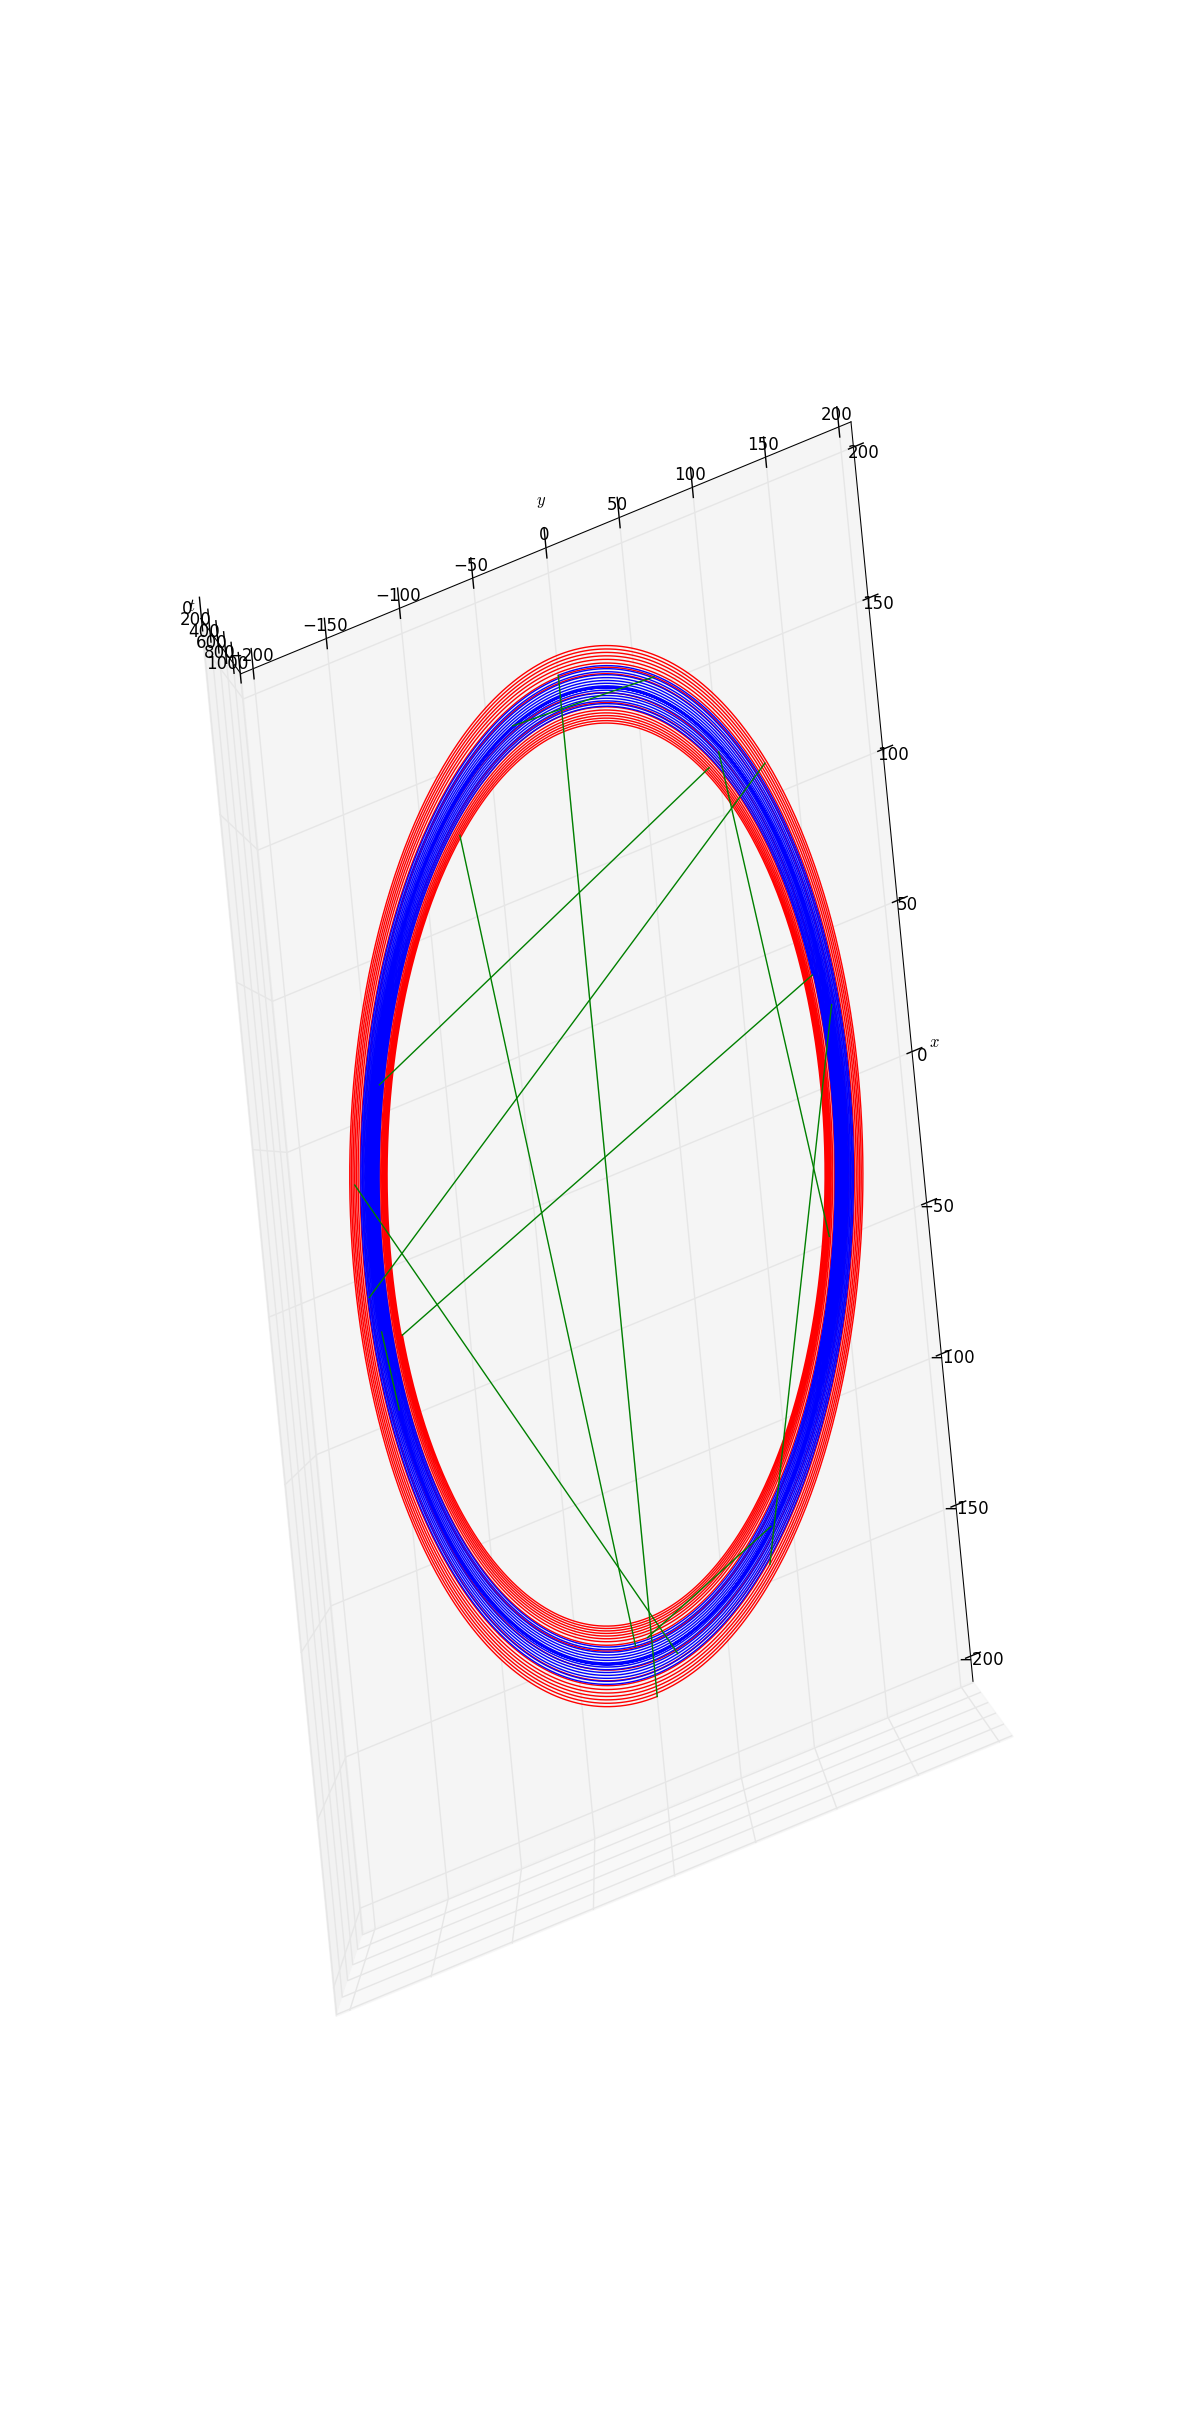

In [3]:
saturn = Body{Float64}(4e4, [0,0], [0,0])

f_grav(b1::Body, b2::Body) = -1*b1.mass*b2.mass/norm(b1.r - b2.r)^3 .* (b1.r - b2.r) # 2-body F_grav
f_grav(ref::Body, b1::Body, b2::Body) = f_grav(ref, b1) + f_grav(ref, b2) # 3-body F_grav

a(ref::Body, b1::Body, b2::Body) = f_grav(ref, b1, b2) ./ ref.mass # get acceleration via 3-body F_grav
a(b1::Body, b2::Body) = a(b1, b2, saturn) # get acceleration via 3-body F_grav and saturn

# declare all the things
dt = .1
t_max = 1000
times = collect(0:dt:t_max)
m1_array = Array(Body{Float64}, length(times))
m2_array = Array(Body{Float64}, length(times))

m1_array[1] = Body{Float64}(1, [-155, 0], [0, -16.1])
m2_array[1] = Body{Float64}(4, [150, 0], [0, 16.3])

# Lets Verlet
for i in 2:length(times)
    # define next entry
    m1_array[i] = copy(m1_array[i-1])
    m2_array[i] = copy(m2_array[i-1])
    
    # save acc because it is used multiple times
    a_m1 = a(m1_array[i-1], m2_array[i-1])
    a_m2 = a(m2_array[i-1], m1_array[i-1])
    
    # $x_{n+1} = x_n + v_n*dt + 1/2 * a_n * dt^2$
    m1_array[i].r = m1_array[i-1].r + m1_array[i-1].v .* dt + 1/2 .* a_m1 .* dt^2
    m2_array[i].r = m2_array[i-1].r + m2_array[i-1].v .* dt + 1/2 .* a_m2 .* dt^2
    
    # $v_{n+1} = v_n + 1/2 * (a_n + a_{n+1}) * dt$
    m1_array[i].v = m1_array[i-1].v + 1/2 .* (a_m1 + a(m1_array[i], m2_array[i])) .* dt
    m2_array[i].v = m2_array[i-1].v + 1/2 .* (a_m2 + a(m2_array[i], m1_array[i])) .* dt
end


# 3d Plot *yay*
using PyPlot

figure(figsize=(15,30))
gca(projection="3d")
gca()[:view_init](5., 10.)
plot([b.r[1] for b in m1_array], [b.r[2] for b in m1_array], "r", zs=times, label="Mond 1")
plot([b.r[1] for b in m2_array], [b.r[2] for b in m2_array], "b", zs=times, label="Mond 2")

# connect moons all 100 timesteps
for i in 1:Int(100/dt):length(times)
    plot(linspace(m1_array[i].r[1],m2_array[i].r[1], 100), linspace(m1_array[i].r[2],m2_array[i].r[2], 100), "g", zs=times[i])
end
xlabel(L"x")
ylabel(L"y")
zlabel(L"t")

;

Wie man sieht tauschen die Monde ihre Position: Der innere Mond geht auf die auessere Bahn und umgekehrt. Damit stoppt beschleuningt der auessere Mond und der Innere bremst ab.

(Fuer besser Plot Ideen bin ich immer zu haben)